**Processamento Digital de Imagens - 2022/01**<br/>
**Engenharia da Computação**<br/>
**Aluno:** Gabriel Soares Baptista, 2018102117<br/>

### Questão 1

In [2]:
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt

### Funções auxiliares

In [3]:
def get_laplacian_mask() -> np.array:
    """ Retorna o filtro laplaciano de ordem 3 """
    return np.array([-1, -1, -1, -1, 8, -1, -1, -1, -1]).reshape(3, 3)


def get_sobel_mask(orientation: str) -> np.array:
    """ Retorna o filtro de Sobel de ordem 3 na orientação informada """
    if orientation == 'h':
        return np.array([1, 2, 1, 0 , 0, 0,-1, -2, -1]).reshape(3, 3)
    elif orientation == 'v':
        return np.array([-1, 0, 1, -2, 0, 2, -1, 0, 1]).reshape(3, 3)
    else:
        raise ValueError(f'Orientation {orientation} is invalid.')


def get_mean_mask(order:int =3) -> np.array:
    """ Retorna um filtro de média da ordem informada """
    return np.ones(shape=(order, order)) * 1/(order**2)


def image_normalize(image: np.array) -> np.array:
    """ Normaliza os valores da imagens para o intervalo [0, 255] """
    v_min = float(image.min())
    v_max = float(image.max())
    return np.round((image - v_min)/(v_max - v_min) * 255)


def convolve(image: np.array, mask: np.array) -> np.array:
    """
    Aplica uma convolução em `image` utilizando-se a máscara informada.
    """
    # flip mask
    mask = np.rot90(mask, 2)
    mask_size = mask.shape[0]

    # apply padding
    padded_image = np.pad(image, mask_size//2)
    image_convolved = np.zeros(image.shape)

    # iterate over image computing the new pixel values
    N, M = image.shape

    for i in range(0, N):
        for j in range(0, M):
            image_crop = padded_image[i: i + mask_size, j: j + mask_size]
            image_convolved[i, j] = (image_crop * mask).sum()

    return image_convolved


def gamma_transform(image: np.array, c: float, gamma: float) -> np.array:
    """ Aplica uma transformação de potência na imagem """
    return c * image**gamma

def image_plot(image: np.array, size: Tuple[int, int], scaled: bool = False) -> None:
    """ Plota a imagem com as informações passadas """
    plt.figure(figsize=size)
    if not scaled:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.show()

### Resolução

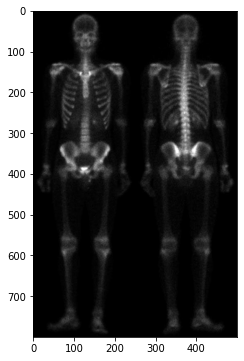

In [4]:
image = plt.imread('../images/Fig3.46(a).jpg').astype('double')
image_plot(image, (5, 6))

A figura acima mostra uma varredura óssea de corpo inteiro. O objetivo é realçar a imagem de forma a aumentar sua nitidez para evidenciar os detalhes da varredura.

O procedimento que será aplicado consiste em:
1. Utilizar o laplaciano para salientar os detalhes finos;
2. Utilizar o gradiente para realçar as bordas proeminentes;
3. Amplificação da faixa dinâmica dos níveis de intensidade utilizando uma transformação.

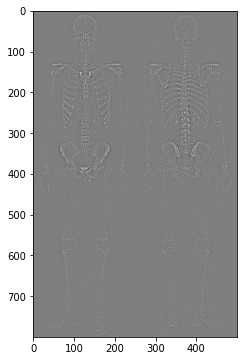

In [5]:
# compute laplacian of the image
laplacian_filter =  get_laplacian_mask()
laplacian_result = convolve(image, laplacian_filter)

# show laplacian
image_plot(laplacian_result, (5, 6), False)

Como podemos ver, o laplaciano é um filtro de detecção de bordas. Embora o operador laplaciano responda a transições de intensidade, raramente se utiliza na prática para detecção de bordas, uma vez que é relativamente sensível a ruídos.
Portanto, como podemos supor, a soma da imagem original com seu laplaciano gera uma imagem muito ruidosa.

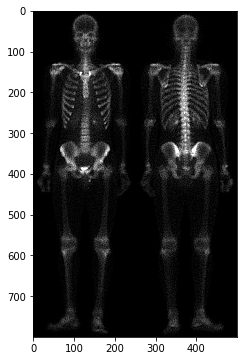

In [6]:
improved_image = image + laplacian_result
image_plot(improved_image, (5, 6), True)

Um método de reduzir esse tipo de ruido seria a aplicação de um filtro de mediana, entretanto, por se tratar de um filtro não linear pode acabar removendo características importantes que são cruciais em imagens médicas.

Portanto, uma alternativa seria utilizar o gradiente em vez do laplaciano. Uma vez que o laplaciano se trata de um operador de derivada de segunda ordem, tem a grande vantagem de realçar detalhes finos, contudo, produz resultados com mais ruído do que o gradiente.

Dessa forma, deseja-se suavizar o gradiente com um filtro de média e multiplicá-lo pela imagem laplaciana, gerando-se um filtro suavizado de gradiente.

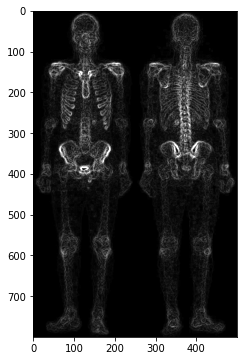

In [7]:
# get filters
vertical_sobel = get_sobel_mask('v')
horizontal_sobel = get_sobel_mask('h')

# compute convolution
gv = convolve(image, vertical_sobel)
gh = convolve(image, horizontal_sobel)
gradient_result = (gv**2 + gh**2)**0.5

# show gradient
image_plot(gradient_result, (5, 6), True)

Como é possível perceber, o gradiente tem uma resposta média mais forte nas áreas de transições significativas de intensidade (rampas e degraus) quando comparado ao laplaciano. Embora a resposta do gradiente à ruído e detalhes finos seja mais baixa, pode-se atenuar os ruídos existentes pelo filtro de média.

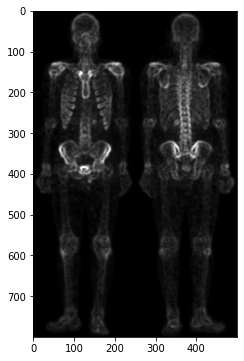

In [8]:
# compute convolution with mean filter
mean_mask = get_mean_mask(5)
smoothed_gradient = convolve(gradient_result, mean_mask)

# show smoothed gradient
image_plot(smoothed_gradient, (5, 6), True)

Com a imagem suavizada pelo filtro de média, pode-se multiplicá-lo pela imagem laplaciana, considerando o gradiente suavizado como uma imagem de máscara. A ideia é que o produto será capaz de preservar os detalhes das áreas de transição acentuadas enquanto irá reduzir o ruído nas áreas mais uniformes, uma espécie de combinação entre o filtro de Laplace e Sobel.

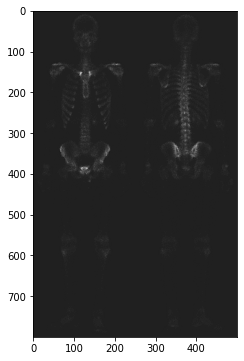

In [9]:
# show smoothed gradient multiplied by laplacian
smoothed_image = image_normalize(improved_image * smoothed_gradient)
image_plot(smoothed_image, (5, 6), False)

Adiciona-e o resultado acima na imagem original, realçando-a.

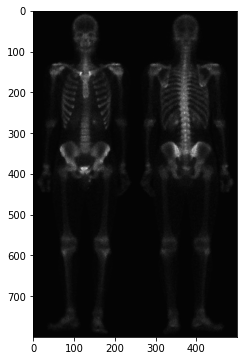

In [10]:
improved_image2 = image_normalize(image + smoothed_image)
image_plot(improved_image2, (5, 6), True)

Como a equalização de histogramas não deve obter uma boa resposta na imagem acima, visto que a distribuição de intensidade apresenta uma grande quantidade de valores mais escuros, portanto, utiliza-se uma transformação de potência para alargar a faixa dinâmica da imagem realçada.

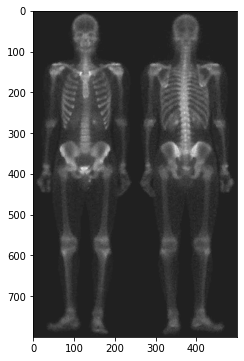

In [11]:
gamma_transformed = gamma_transform(improved_image2, c=1, gamma=0.5)
image_plot(gamma_transformed, (5, 6), False)

Portanto, podemos sintetizar todas imagens para gerar uma imagem semelhante ao capítulo 3.7 do livro base.

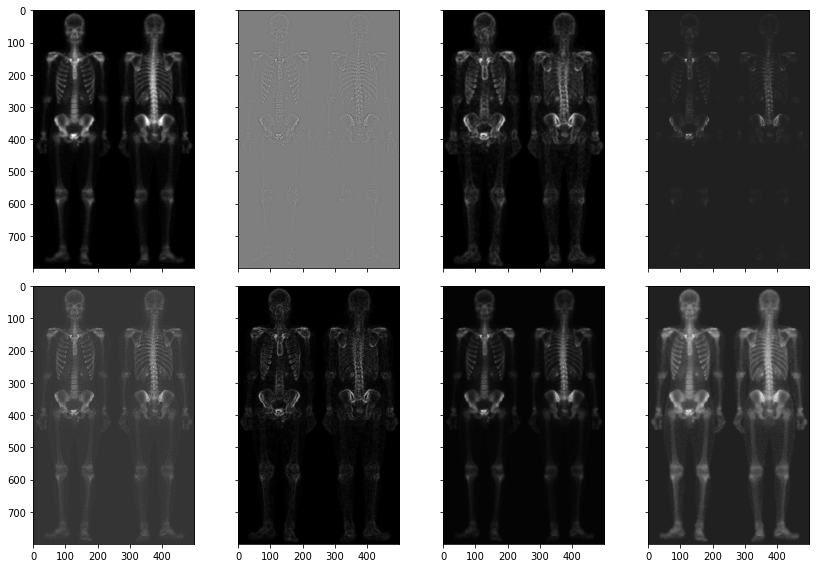

In [12]:
fig, axs = plt.subplots(2, 4, figsize=(12, 8), sharey=True, sharex=True)
# row 1
axs[0][0].imshow(image, cmap='gray')
axs[0][1].imshow(laplacian_result, cmap='gray')
axs[0][2].imshow(smoothed_gradient, cmap='gray')
axs[0][3].imshow(smoothed_image, cmap='gray')
# row 2
axs[1][0].imshow(improved_image, cmap='gray')
axs[1][1].imshow(gradient_result, cmap='gray')
axs[1][2].imshow(improved_image2, cmap='gray')
axs[1][3].imshow(gamma_transformed, cmap='gray')
plt.tight_layout()
plt.show()